# Chlorophyll depth profiles throughout the Arctic Ocean

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

# input file

In [3]:
#### print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

 GNG595


What year? (year)


 20yrclim


In [4]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [7]:
### 20 year climatology GNG595 from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim/clim_20yr_GNG595_*', recursive=True),
                      key=numericalSort)

In [8]:
new = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [9]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [10]:
chla_new = np.nansum(np.stack([new.ppChl, new.mp1Chl, new.diazChl, new.diat1Chl, new.mp2Chl, new.diat2Chl, new.mp3Chl, new.diat3Chl, new.mp4Chl]), axis =0)
chla_new[chla_new<=0]=np.nan

In [11]:
Chla_vertical_integrated = np.nansum(chla_new, axis=1)*10/150 
#Chla_vertical_integrated = np.nanmean(chla_new, axis=1)
# Multiplying by the depth of the column, and dividing by the depth over the full layer. 

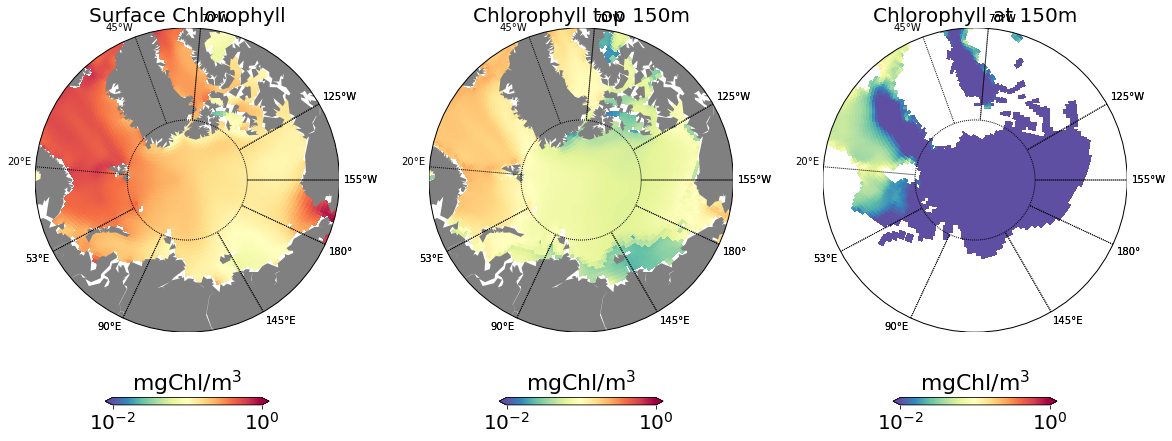

In [12]:
fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(chla_new[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('Surface Chlorophyll', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chlo = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(Chla_vertical_integrated, axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chlo,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('Chlorophyll top 150m', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
tlon, tlat, chl = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(chla_new[:,14,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('Chlorophyll at 150m', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chla_AO_surface&150m_'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

In [14]:
obsfiles_regrid = sorted(glob.glob('/glade/scratch/gabyn/SeaWiFS/monthly_climatology_reggrid/regrid_chl_ocx_SeaWiFS.*.nc', recursive=True),
                      key=numericalSort)
obss = xr.open_mfdataset(obsfiles_regrid,concat_dim='time',combine='nested')

In [16]:
diat1_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat1Chl.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,combine='by_coords')

diat2_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat2Chl.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,combine='by_coords')

diat3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat3Chl.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,combine='by_coords')

mp1_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp1Chl.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,combine='by_coords')

mp2_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp2Chl.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,combine='by_coords')

mp3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp3Chl.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,combine='by_coords')

mp4_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp4Chl.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,combine='by_coords')

pp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_ppChl.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,combine='by_coords')

diaz_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diazChl.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,combine='by_coords')

In [17]:
phytoChl = np.stack([pp_ds.ppChl, mp1_ds.mp1Chl, diaz_ds.diazChl, 
                               diat1_ds.diat1Chl, mp2_ds.mp2Chl, diat2_ds.diat2Chl, 
                               mp3_ds.mp3Chl, diat3_ds.diat3Chl, mp4_ds.mp4Chl])

phytoChl = np.nansum(phytoChl, axis =(0))

In [18]:
phytoChl.shape

(12, 15, 180, 360)

In [19]:
# Model Chlorophyll for every region 
model_ao = np.nanmean(phytoChl[:,:,170:180,:], axis=(2,3))
model_cs = np.nanmean(phytoChl[:,:,149:170,0:25], axis=(2,3))
model_bs = np.nanmean(phytoChl[:,:,149:170,25:55], axis=(2,3))
model_ca = np.nanmean(phytoChl[:,:,149:170,55:110], axis=(2,3))
model_bb = np.nanmean(phytoChl[:,:,149:170,110:135], axis=(2,3))
model_ess = np.nanmean(phytoChl[:,:,149:170,325:360], axis=(2,3))
model_ls = np.nanmean(phytoChl[:,:,149:170,270:325], axis=(2,3))
model_ns = np.nanmean(phytoChl[:,:,149:170,155:205], axis=(2,3))
model_bts =np.nanmean(phytoChl[:,:,149:170,205:233], axis=(2,3))
model_ks = np.nanmean(phytoChl[:,:,149:170,233:270], axis=(2,3))

# Observed Chlorophyll for every region. 

obs_ao = np.nanmean(obss.chl_ocx[:,170:180,:], axis=(1,2))
obs_cs = np.nanmean(obss.chl_ocx[:,149:170,0:25], axis = (1,2))
obs_bs = np.nanmean(obss.chl_ocx[:,149:170,25:55], axis = (1,2))
obs_ca = np.nanmean(obss.chl_ocx[:,149:170,55:110], axis = (1,2))
obs_bb = np.nanmean(obss.chl_ocx[:,149:170,110:135], axis = (1,2))
obs_ess = np.nanmean(obss.chl_ocx[:,149:170,325:360], axis = (1,2))
obs_ls = np.nanmean(obss.chl_ocx[:,149:170,270:325], axis = (1,2))
obs_ns = np.nanmean(obss.chl_ocx[:,149:170,155:205], axis = (1,2))
obs_bts =np.nanmean(obss.chl_ocx[:,149:170,205:233], axis = (1,2))
obs_ks = np.nanmean(obss.chl_ocx[:,149:170,233:270], axis = (1,2))

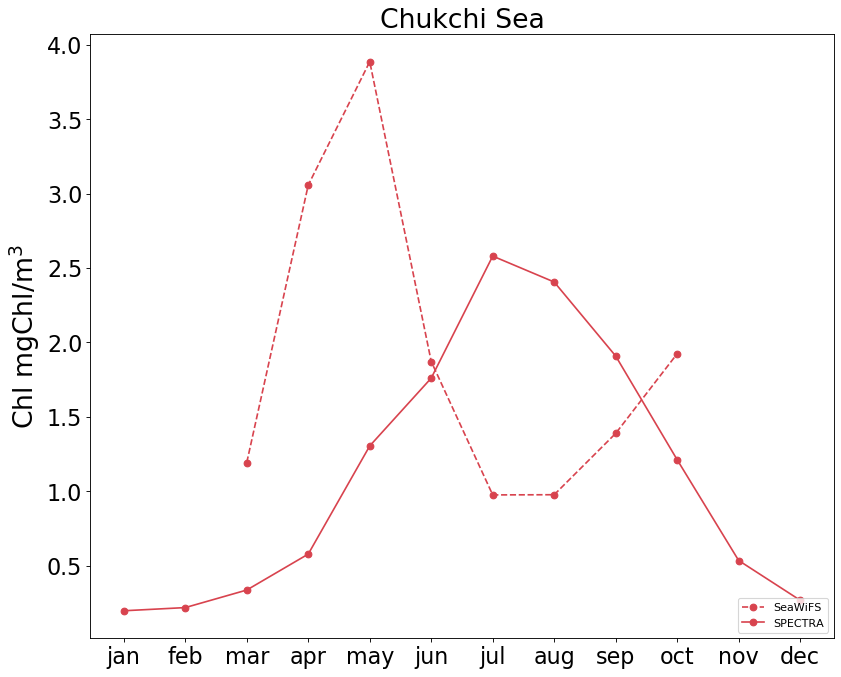

In [20]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_cs, '--o',color=cmap(1),label='SeaWiFS')
pylab.plot(months,np.nansum(model_cs,axis=1), '-o',color=cmap(1),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Chukchi Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Chukchi_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

## Plot the depth profiles at each month of the year 

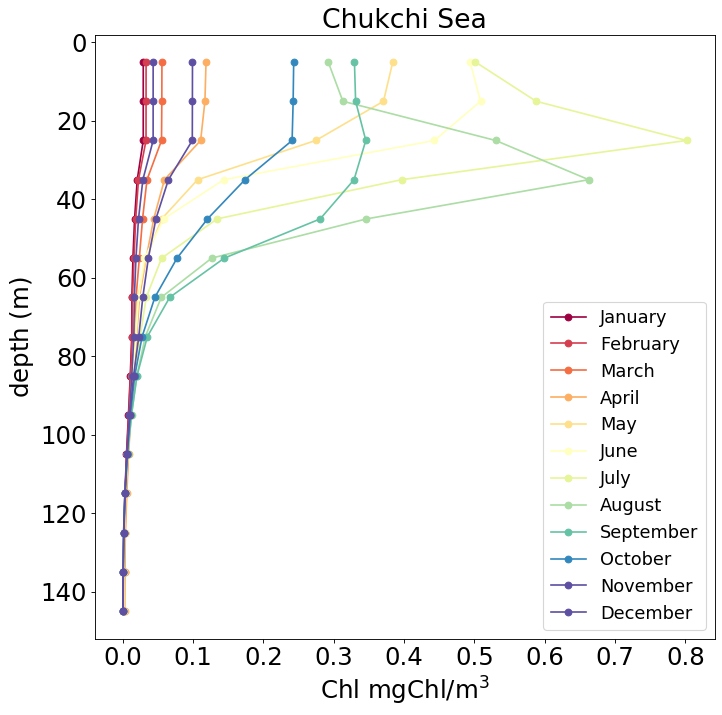

In [21]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 11)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(model_cs[0,:],new.z_t_150m/100, '-o', color=cmap(0),label='January')
pylab.plot(model_cs[1,:],new.z_t_150m/100, '-o',color=cmap(1),label='February')
pylab.plot(model_cs[2,:],new.z_t_150m/100, '-o',color=cmap(2),label='March')
pylab.plot(model_cs[3,:],new.z_t_150m/100, '-o',color=cmap(3),label='April')
pylab.plot(model_cs[4,:],new.z_t_150m/100, '-o',color=cmap(4),label='May')
pylab.plot(model_cs[5,:],new.z_t_150m/100, '-o',color=cmap(5),label='June')
pylab.plot(model_cs[6,:],new.z_t_150m/100, '-o',color=cmap(6),label='July')
pylab.plot(model_cs[7,:],new.z_t_150m/100, '-o',color=cmap(7),label='August')
pylab.plot(model_cs[8,:],new.z_t_150m/100, '-o',color=cmap(8),label='September')
pylab.plot(model_cs[9,:],new.z_t_150m/100, '-o',color=cmap(9),label='October')
pylab.plot(model_cs[10,:],new.z_t_150m/100, '-o',color=cmap(10),label='November')
pylab.plot(model_cs[11,:],new.z_t_150m/100, '-o',color=cmap(11),label='December')

pylab.legend(loc='lower right', fontsize=16)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Chl $mg Chl$/$m^3$', fontsize=22)
pylab.title('Chukchi Sea', fontsize=24)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/CS_Chla_depth_monthly_'+year+'year.png', dpi=600, bbox_inches='tight')

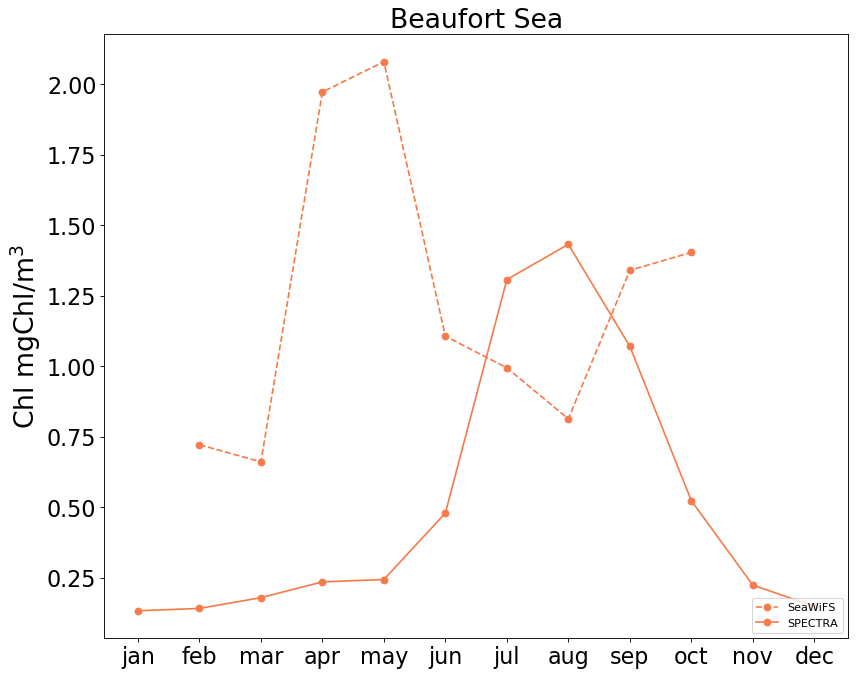

In [22]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_bs, '--o', color=cmap(2),label='SeaWiFS')
pylab.plot(months,np.nansum(model_bs,axis=1), '-o', color=cmap(2),label='SPECTRA')


pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Beaufort Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Beaufort_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

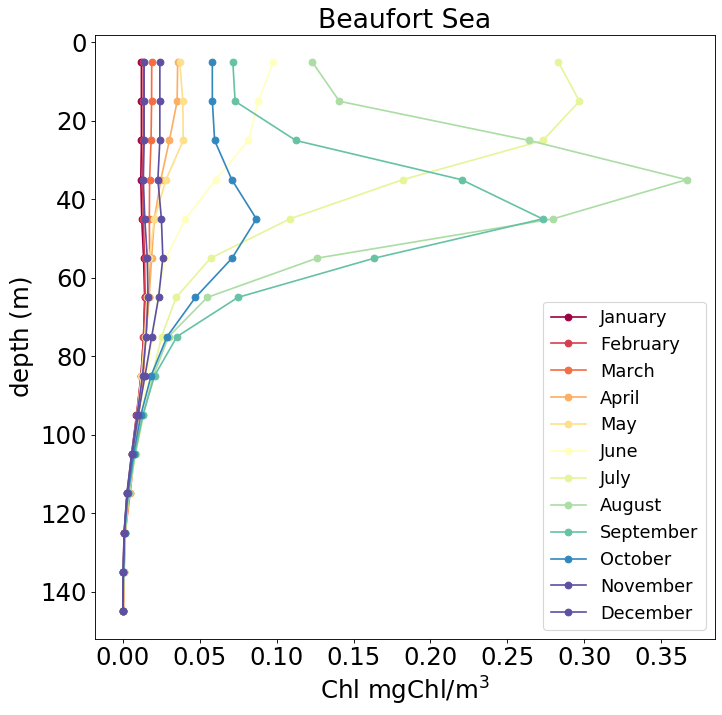

In [23]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 11)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(model_bs[0,:],new.z_t_150m/100, '-o', color=cmap(0),label='January')
pylab.plot(model_bs[1,:],new.z_t_150m/100, '-o',color=cmap(1),label='February')
pylab.plot(model_bs[2,:],new.z_t_150m/100, '-o',color=cmap(2),label='March')
pylab.plot(model_bs[3,:],new.z_t_150m/100, '-o',color=cmap(3),label='April')
pylab.plot(model_bs[4,:],new.z_t_150m/100, '-o',color=cmap(4),label='May')
pylab.plot(model_bs[5,:],new.z_t_150m/100, '-o',color=cmap(5),label='June')
pylab.plot(model_bs[6,:],new.z_t_150m/100, '-o',color=cmap(6),label='July')
pylab.plot(model_bs[7,:],new.z_t_150m/100, '-o',color=cmap(7),label='August')
pylab.plot(model_bs[8,:],new.z_t_150m/100, '-o',color=cmap(8),label='September')
pylab.plot(model_bs[9,:],new.z_t_150m/100, '-o',color=cmap(9),label='October')
pylab.plot(model_bs[10,:],new.z_t_150m/100, '-o',color=cmap(10),label='November')
pylab.plot(model_bs[11,:],new.z_t_150m/100, '-o',color=cmap(11),label='December')

pylab.legend(loc='lower right', fontsize=16)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Chl $mg Chl$/$m^3$', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.title('Beaufort Sea', fontsize=24)
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/BS_Chla_depth_monthly_'+year+'year.png', dpi=600, bbox_inches='tight')

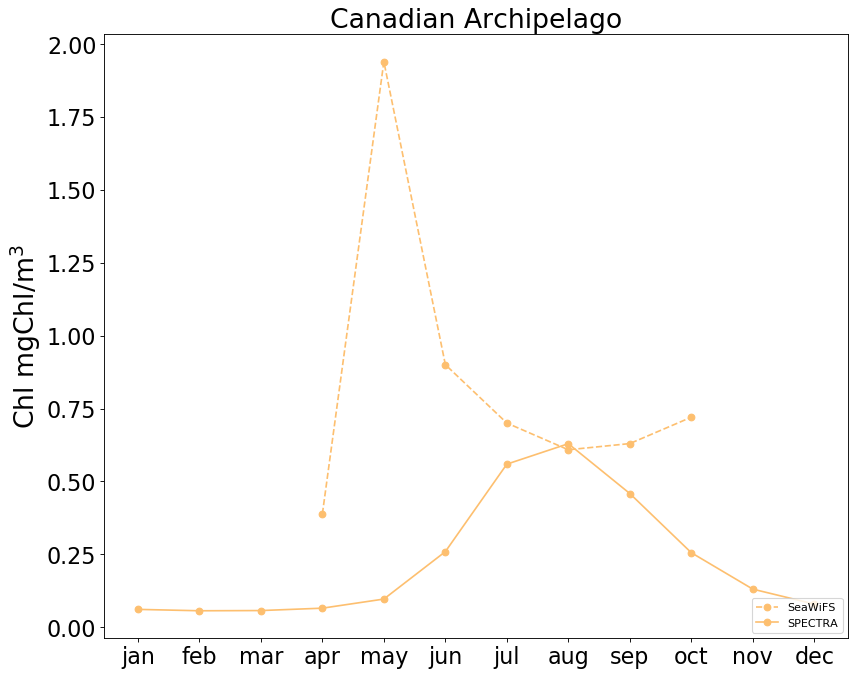

In [24]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ca, '--o', color=cmap(3),label='SeaWiFS')
pylab.plot(months,np.nansum(model_ca,axis=1), '-o', color=cmap(3),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Canadian Archipelago', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Canadian_Archipelago_'+year+'year.png', dpi=600, bbox_inches='tight')

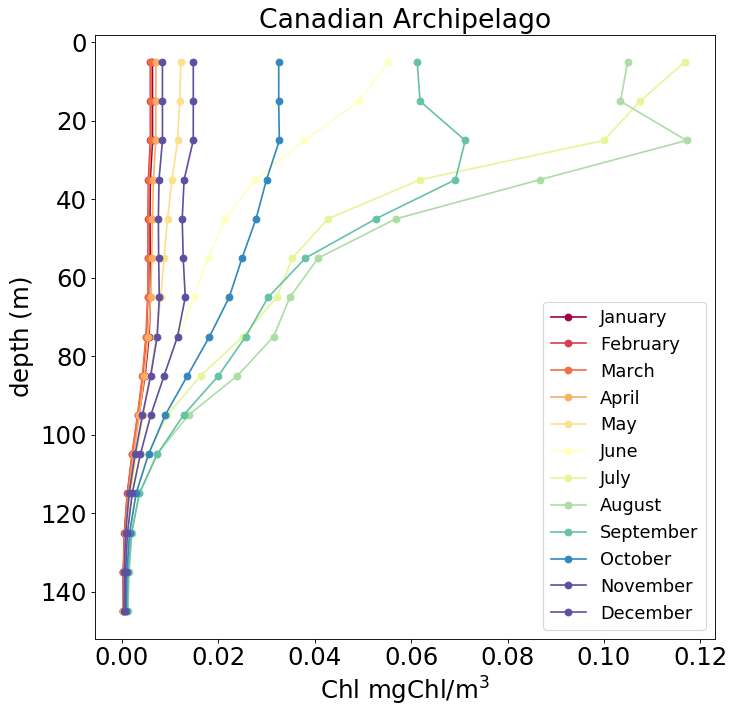

In [25]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 11)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(model_ca[0,:],new.z_t_150m/100, '-o', color=cmap(0),label='January')
pylab.plot(model_ca[1,:],new.z_t_150m/100, '-o',color=cmap(1),label='February')
pylab.plot(model_ca[2,:],new.z_t_150m/100, '-o',color=cmap(2),label='March')
pylab.plot(model_ca[3,:],new.z_t_150m/100, '-o',color=cmap(3),label='April')
pylab.plot(model_ca[4,:],new.z_t_150m/100, '-o',color=cmap(4),label='May')
pylab.plot(model_ca[5,:],new.z_t_150m/100, '-o',color=cmap(5),label='June')
pylab.plot(model_ca[6,:],new.z_t_150m/100, '-o',color=cmap(6),label='July')
pylab.plot(model_ca[7,:],new.z_t_150m/100, '-o',color=cmap(7),label='August')
pylab.plot(model_ca[8,:],new.z_t_150m/100, '-o',color=cmap(8),label='September')
pylab.plot(model_ca[9,:],new.z_t_150m/100, '-o',color=cmap(9),label='October')
pylab.plot(model_ca[10,:],new.z_t_150m/100, '-o',color=cmap(10),label='November')
pylab.plot(model_ca[11,:],new.z_t_150m/100, '-o',color=cmap(11),label='December')

pylab.legend(loc='lower right', fontsize=16)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Chl $mg Chl$/$m^3$', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.title('Canadian Archipelago', fontsize=24)
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/CA_Chla_depth_monthly_'+year+'year.png', dpi=600, bbox_inches='tight')

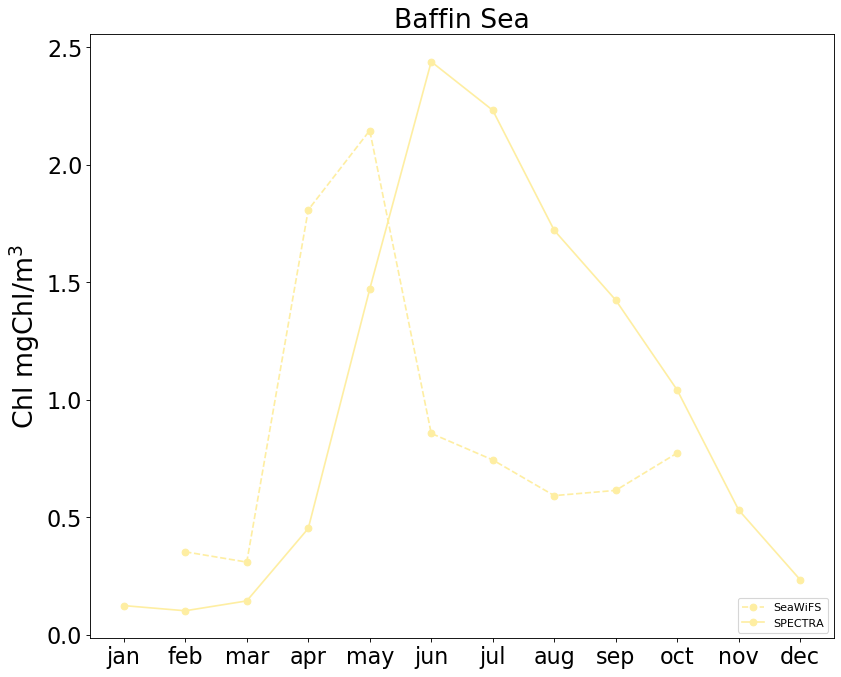

In [26]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_bb, '--o', color=cmap(4),label='SeaWiFS')
pylab.plot(months,np.nansum(model_bb,axis=1), '-o', color=cmap(4),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Baffin Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Baffin_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

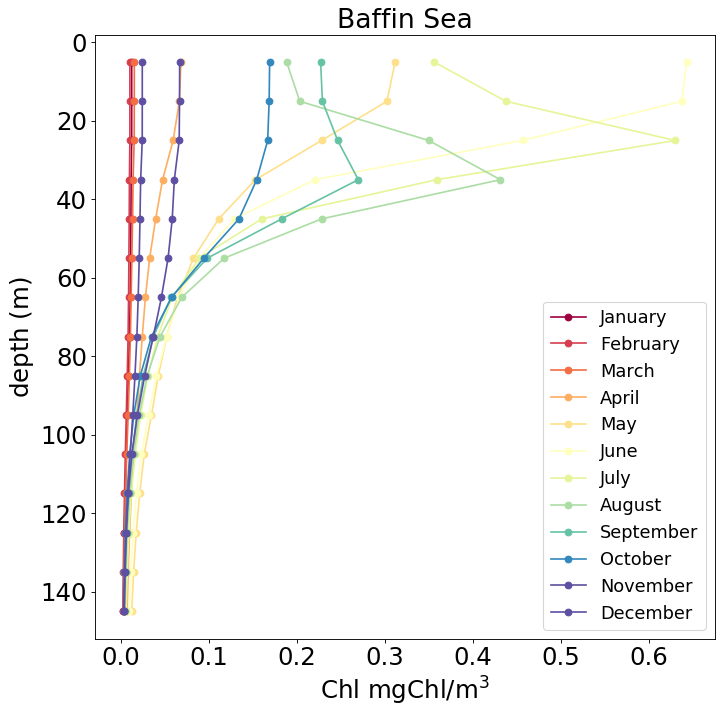

In [27]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 11)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(model_bb[0,:],new.z_t_150m/100, '-o', color=cmap(0),label='January')
pylab.plot(model_bb[1,:],new.z_t_150m/100, '-o',color=cmap(1),label='February')
pylab.plot(model_bb[2,:],new.z_t_150m/100, '-o',color=cmap(2),label='March')
pylab.plot(model_bb[3,:],new.z_t_150m/100, '-o',color=cmap(3),label='April')
pylab.plot(model_bb[4,:],new.z_t_150m/100, '-o',color=cmap(4),label='May')
pylab.plot(model_bb[5,:],new.z_t_150m/100, '-o',color=cmap(5),label='June')
pylab.plot(model_bb[6,:],new.z_t_150m/100, '-o',color=cmap(6),label='July')
pylab.plot(model_bb[7,:],new.z_t_150m/100, '-o',color=cmap(7),label='August')
pylab.plot(model_bb[8,:],new.z_t_150m/100, '-o',color=cmap(8),label='September')
pylab.plot(model_bb[9,:],new.z_t_150m/100, '-o',color=cmap(9),label='October')
pylab.plot(model_bb[10,:],new.z_t_150m/100, '-o',color=cmap(10),label='November')
pylab.plot(model_bb[11,:],new.z_t_150m/100, '-o',color=cmap(11),label='December')

pylab.legend(loc='lower right', fontsize=16)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Chl $mg Chl$/$m^3$', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.title('Baffin Sea', fontsize=24)
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Baffin_Sea_Chla_depth_monthly_'+year+'year.png', dpi=600, bbox_inches='tight')

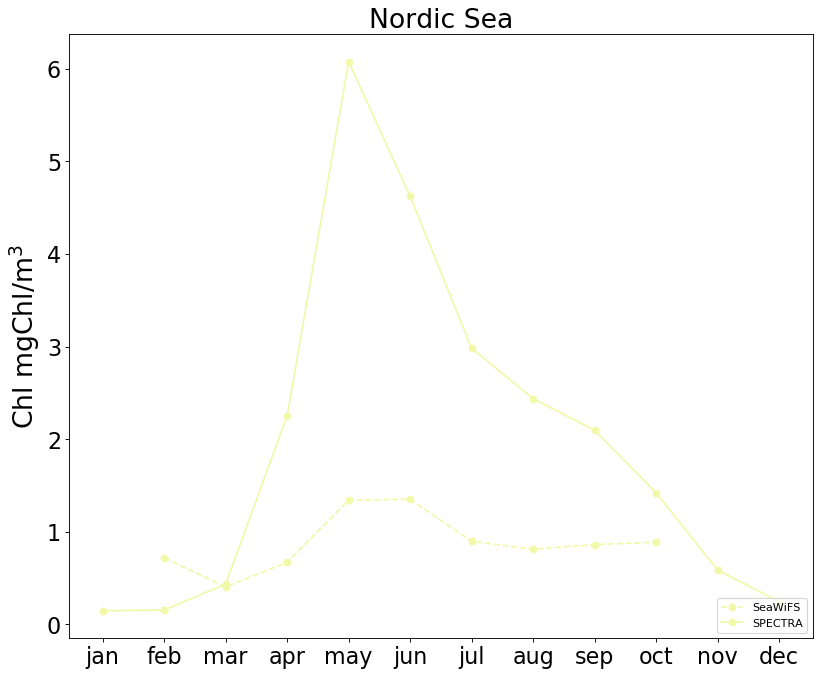

In [28]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ns, '--o', color=cmap(5),label='SeaWiFS')
pylab.plot(months,np.nansum(model_ns,axis=1), '-o', color=cmap(5),label='SPECTRA')


pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Nordic Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Nordic_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

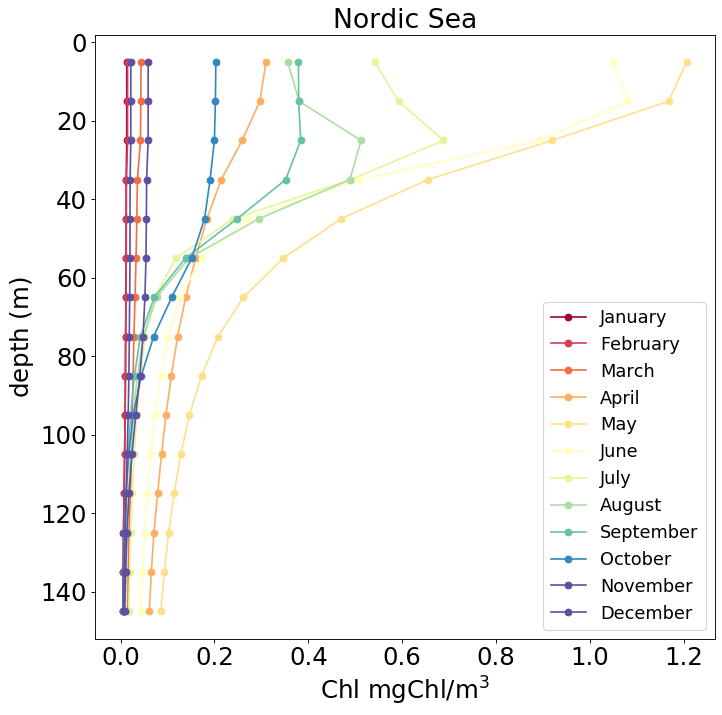

In [29]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 11)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(model_ns[0,:],new.z_t_150m/100, '-o', color=cmap(0),label='January')
pylab.plot(model_ns[1,:],new.z_t_150m/100, '-o',color=cmap(1),label='February')
pylab.plot(model_ns[2,:],new.z_t_150m/100, '-o',color=cmap(2),label='March')
pylab.plot(model_ns[3,:],new.z_t_150m/100, '-o',color=cmap(3),label='April')
pylab.plot(model_ns[4,:],new.z_t_150m/100, '-o',color=cmap(4),label='May')
pylab.plot(model_ns[5,:],new.z_t_150m/100, '-o',color=cmap(5),label='June')
pylab.plot(model_ns[6,:],new.z_t_150m/100, '-o',color=cmap(6),label='July')
pylab.plot(model_ns[7,:],new.z_t_150m/100, '-o',color=cmap(7),label='August')
pylab.plot(model_ns[8,:],new.z_t_150m/100, '-o',color=cmap(8),label='September')
pylab.plot(model_ns[9,:],new.z_t_150m/100, '-o',color=cmap(9),label='October')
pylab.plot(model_ns[10,:],new.z_t_150m/100, '-o',color=cmap(10),label='November')
pylab.plot(model_ns[11,:],new.z_t_150m/100, '-o',color=cmap(11),label='December')

pylab.legend(loc='lower right', fontsize=16)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Chl $mg Chl$/$m^3$', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.title('Nordic Sea', fontsize=24)
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/NS_Chla_depth_monthly_'+year+'year.png', dpi=600, bbox_inches='tight')

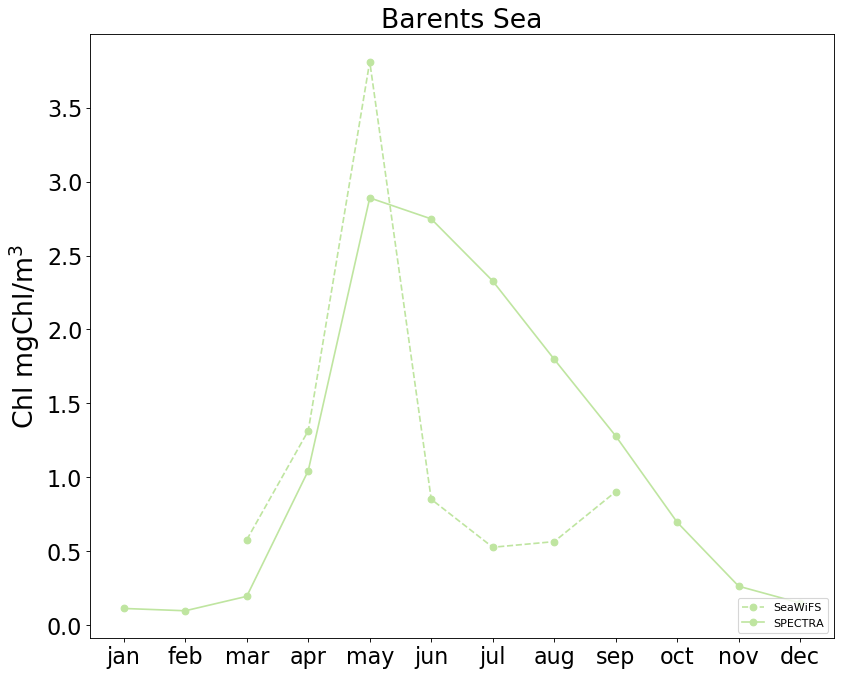

In [30]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_bts, '--o',color=cmap(6),label='SeaWiFS')
pylab.plot(months,np.nansum(model_bts,axis=1), '-o',color=cmap(6),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Barents Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Barents_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

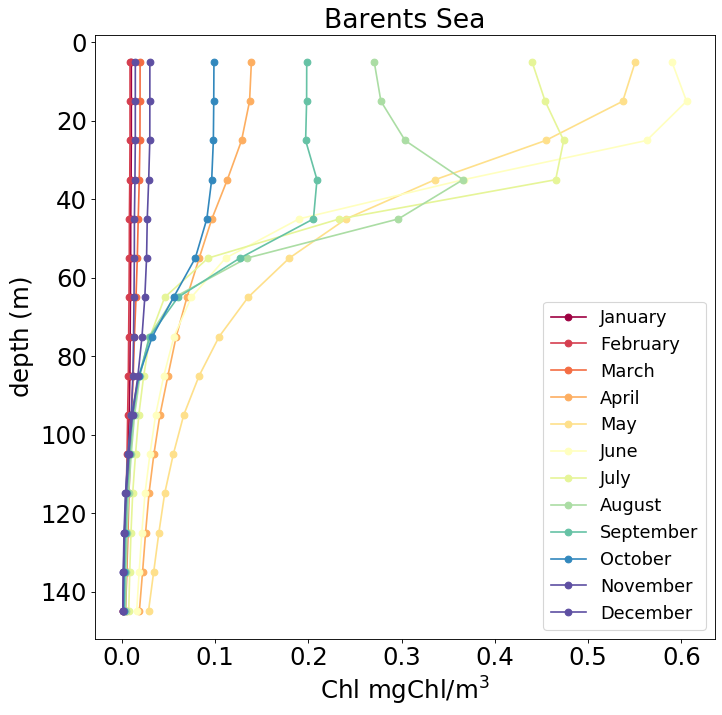

In [31]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 11)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(model_bts[0,:],new.z_t_150m/100, '-o', color=cmap(0),label='January')
pylab.plot(model_bts[1,:],new.z_t_150m/100, '-o',color=cmap(1),label='February')
pylab.plot(model_bts[2,:],new.z_t_150m/100, '-o',color=cmap(2),label='March')
pylab.plot(model_bts[3,:],new.z_t_150m/100, '-o',color=cmap(3),label='April')
pylab.plot(model_bts[4,:],new.z_t_150m/100, '-o',color=cmap(4),label='May')
pylab.plot(model_bts[5,:],new.z_t_150m/100, '-o',color=cmap(5),label='June')
pylab.plot(model_bts[6,:],new.z_t_150m/100, '-o',color=cmap(6),label='July')
pylab.plot(model_bts[7,:],new.z_t_150m/100, '-o',color=cmap(7),label='August')
pylab.plot(model_bts[8,:],new.z_t_150m/100, '-o',color=cmap(8),label='September')
pylab.plot(model_bts[9,:],new.z_t_150m/100, '-o',color=cmap(9),label='October')
pylab.plot(model_bts[10,:],new.z_t_150m/100, '-o',color=cmap(10),label='November')
pylab.plot(model_bts[11,:],new.z_t_150m/100, '-o',color=cmap(11),label='December')

pylab.legend(loc='lower right', fontsize=16)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Chl $mg Chl$/$m^3$', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.title('Barents Sea', fontsize=24)
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/BTS_Chla_depth_monthly_'+year+'year.png', dpi=600, bbox_inches='tight')

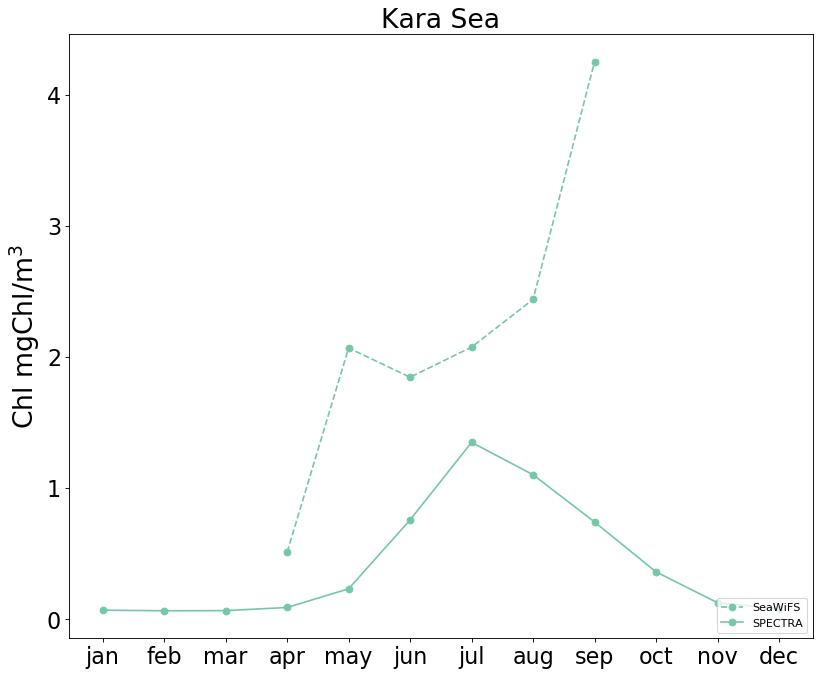

In [32]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ks, '--o', color=cmap(7),label='SeaWiFS')
pylab.plot(months,np.nansum(model_ks,axis=1), '-o', color=cmap(7),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Kara Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Kara_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

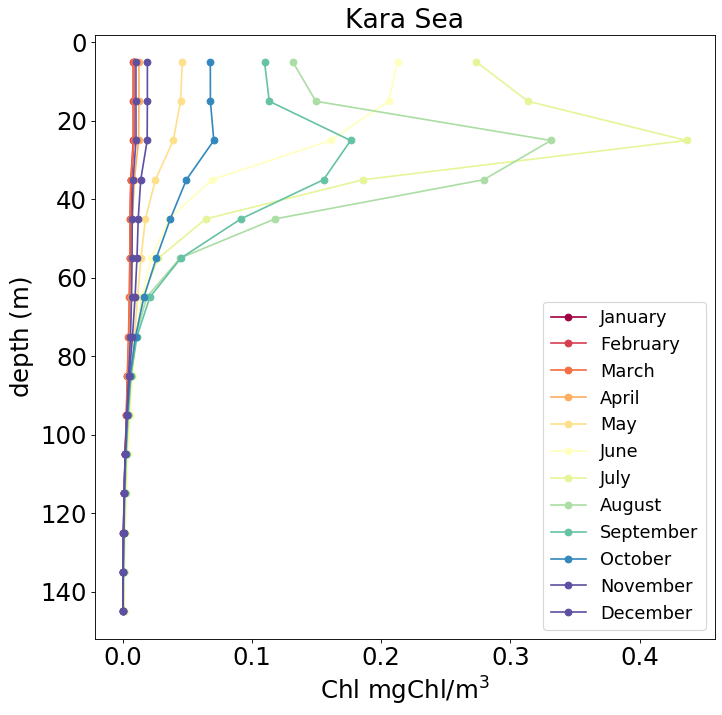

In [33]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 11)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(model_ks[0,:],new.z_t_150m/100, '-o', color=cmap(0),label='January')
pylab.plot(model_ks[1,:],new.z_t_150m/100, '-o',color=cmap(1),label='February')
pylab.plot(model_ks[2,:],new.z_t_150m/100, '-o',color=cmap(2),label='March')
pylab.plot(model_ks[3,:],new.z_t_150m/100, '-o',color=cmap(3),label='April')
pylab.plot(model_ks[4,:],new.z_t_150m/100, '-o',color=cmap(4),label='May')
pylab.plot(model_ks[5,:],new.z_t_150m/100, '-o',color=cmap(5),label='June')
pylab.plot(model_ks[6,:],new.z_t_150m/100, '-o',color=cmap(6),label='July')
pylab.plot(model_ks[7,:],new.z_t_150m/100, '-o',color=cmap(7),label='August')
pylab.plot(model_ks[8,:],new.z_t_150m/100, '-o',color=cmap(8),label='September')
pylab.plot(model_ks[9,:],new.z_t_150m/100, '-o',color=cmap(9),label='October')
pylab.plot(model_ks[10,:],new.z_t_150m/100, '-o',color=cmap(10),label='November')
pylab.plot(model_ks[11,:],new.z_t_150m/100, '-o',color=cmap(11),label='December')

pylab.legend(loc='lower right', fontsize=16)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Chl $mg Chl$/$m^3$', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.title('Kara Sea', fontsize=24)
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/KS_Chla_depth_monthly_'+year+'year.png', dpi=600, bbox_inches='tight')

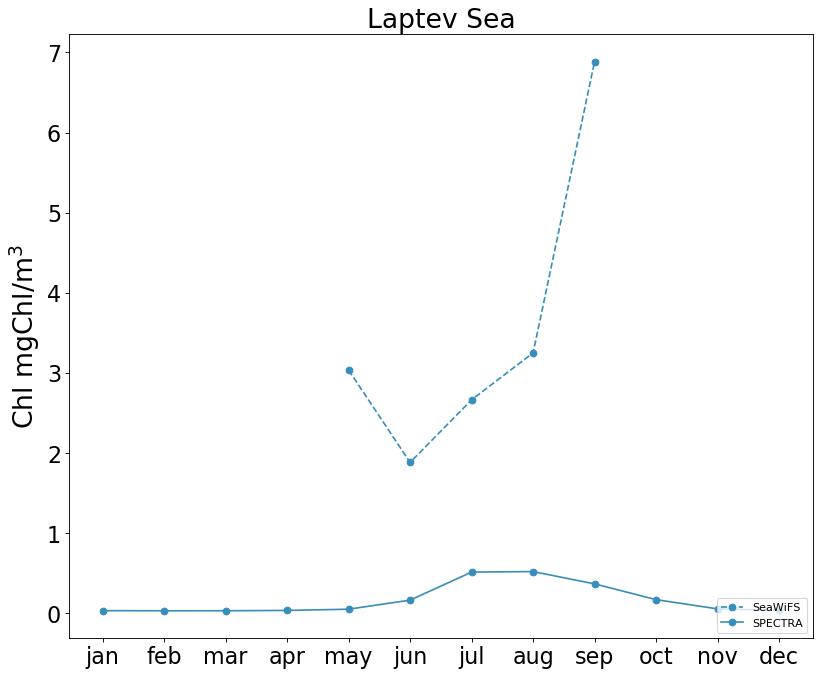

In [34]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ls, '--o', color=cmap(8),label='SeaWiFS')
pylab.plot(months,np.nansum(model_ls,axis=1), '-o', color=cmap(8),label='SPECTRA')


pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Laptev Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Laptev_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

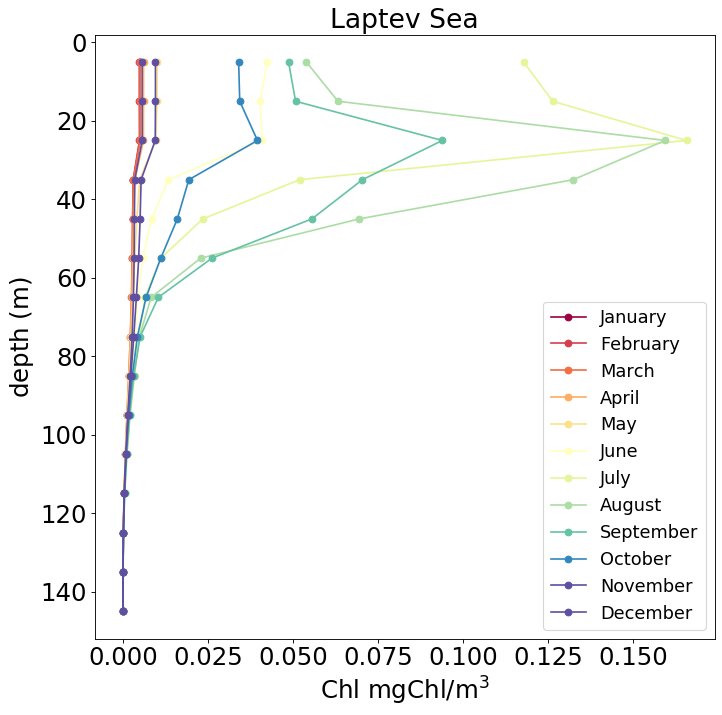

In [35]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 11)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(model_ls[0,:],new.z_t_150m/100, '-o', color=cmap(0),label='January')
pylab.plot(model_ls[1,:],new.z_t_150m/100, '-o',color=cmap(1),label='February')
pylab.plot(model_ls[2,:],new.z_t_150m/100, '-o',color=cmap(2),label='March')
pylab.plot(model_ls[3,:],new.z_t_150m/100, '-o',color=cmap(3),label='April')
pylab.plot(model_ls[4,:],new.z_t_150m/100, '-o',color=cmap(4),label='May')
pylab.plot(model_ls[5,:],new.z_t_150m/100, '-o',color=cmap(5),label='June')
pylab.plot(model_ls[6,:],new.z_t_150m/100, '-o',color=cmap(6),label='July')
pylab.plot(model_ls[7,:],new.z_t_150m/100, '-o',color=cmap(7),label='August')
pylab.plot(model_ls[8,:],new.z_t_150m/100, '-o',color=cmap(8),label='September')
pylab.plot(model_ls[9,:],new.z_t_150m/100, '-o',color=cmap(9),label='October')
pylab.plot(model_ls[10,:],new.z_t_150m/100, '-o',color=cmap(10),label='November')
pylab.plot(model_ls[11,:],new.z_t_150m/100, '-o',color=cmap(11),label='December')

pylab.legend(loc='lower right', fontsize=16)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Chl $mg Chl$/$m^3$', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.title('Laptev Sea', fontsize=24)
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/LS_Chla_depth_monthly_'+year+'year.png', dpi=600, bbox_inches='tight')

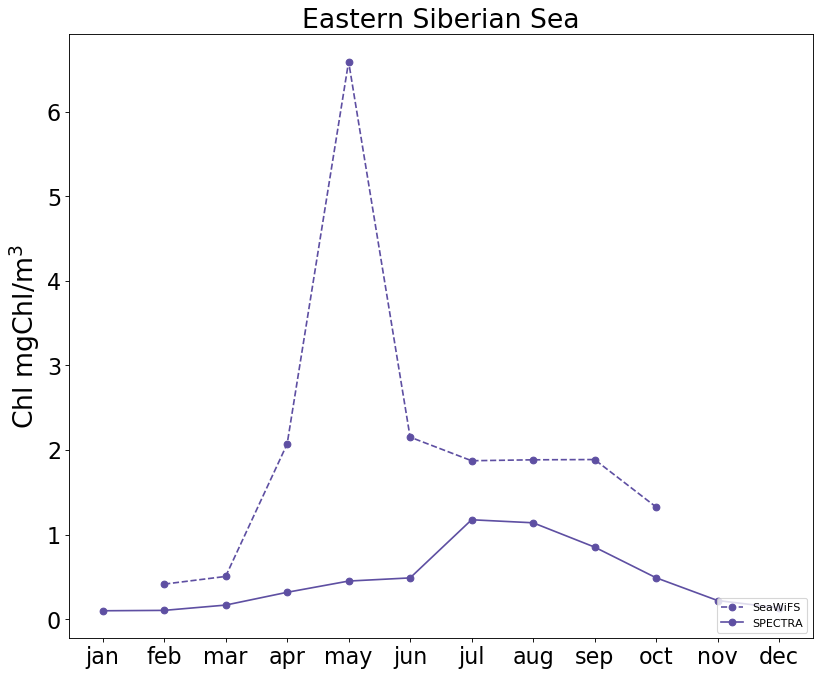

In [36]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ess, '--o', color=cmap(9),label='SeaWiFS')
pylab.plot(months,np.nansum(model_ess,axis=1), '-o', color=cmap(9),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Eastern Siberian Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_ESS_'+year+'year.png', dpi=600, bbox_inches='tight')

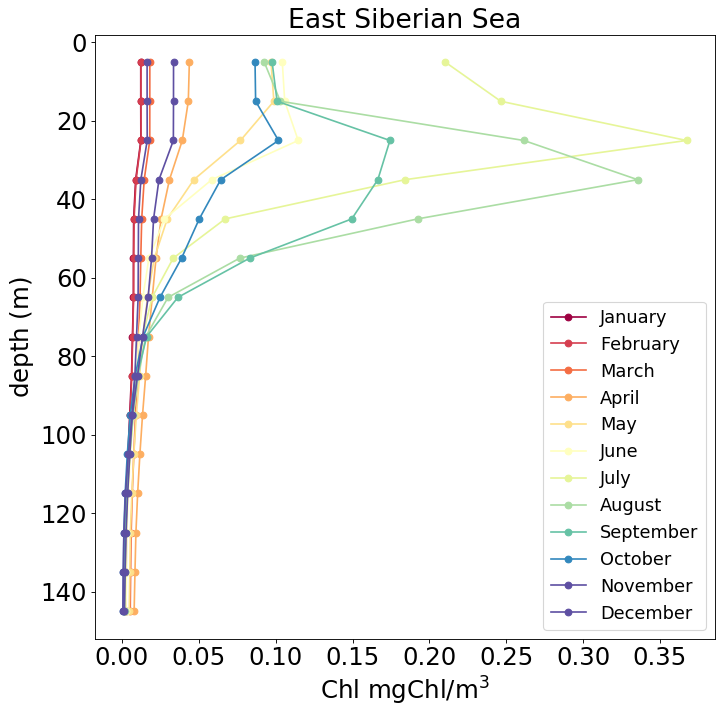

In [37]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 11)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(model_ess[0,:],new.z_t_150m/100, '-o', color=cmap(0),label='January')
pylab.plot(model_ess[1,:],new.z_t_150m/100, '-o',color=cmap(1),label='February')
pylab.plot(model_ess[2,:],new.z_t_150m/100, '-o',color=cmap(2),label='March')
pylab.plot(model_ess[3,:],new.z_t_150m/100, '-o',color=cmap(3),label='April')
pylab.plot(model_ess[4,:],new.z_t_150m/100, '-o',color=cmap(4),label='May')
pylab.plot(model_ess[5,:],new.z_t_150m/100, '-o',color=cmap(5),label='June')
pylab.plot(model_ess[6,:],new.z_t_150m/100, '-o',color=cmap(6),label='July')
pylab.plot(model_ess[7,:],new.z_t_150m/100, '-o',color=cmap(7),label='August')
pylab.plot(model_ess[8,:],new.z_t_150m/100, '-o',color=cmap(8),label='September')
pylab.plot(model_ess[9,:],new.z_t_150m/100, '-o',color=cmap(9),label='October')
pylab.plot(model_ess[10,:],new.z_t_150m/100, '-o',color=cmap(10),label='November')
pylab.plot(model_ess[11,:],new.z_t_150m/100, '-o',color=cmap(11),label='December')

pylab.legend(loc='lower right', fontsize=16)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Chl $mg Chl$/$m^3$', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.title('East Siberian Sea', fontsize=24)
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/ESS_Chla_depth_monthly_'+year+'year.png', dpi=600, bbox_inches='tight')

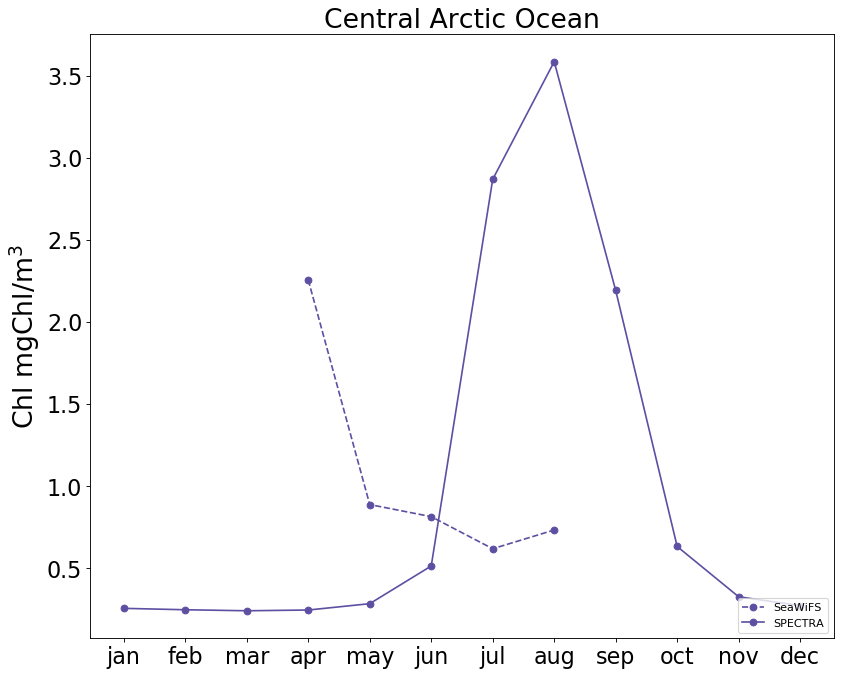

In [38]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ao, '--o', color=cmap(9),label='SeaWiFS')
pylab.plot(months,np.nansum(model_ao,axis=1), '-o', color=cmap(9),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Central Arctic Ocean', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_AO_'+year+'year.png', dpi=600, bbox_inches='tight')

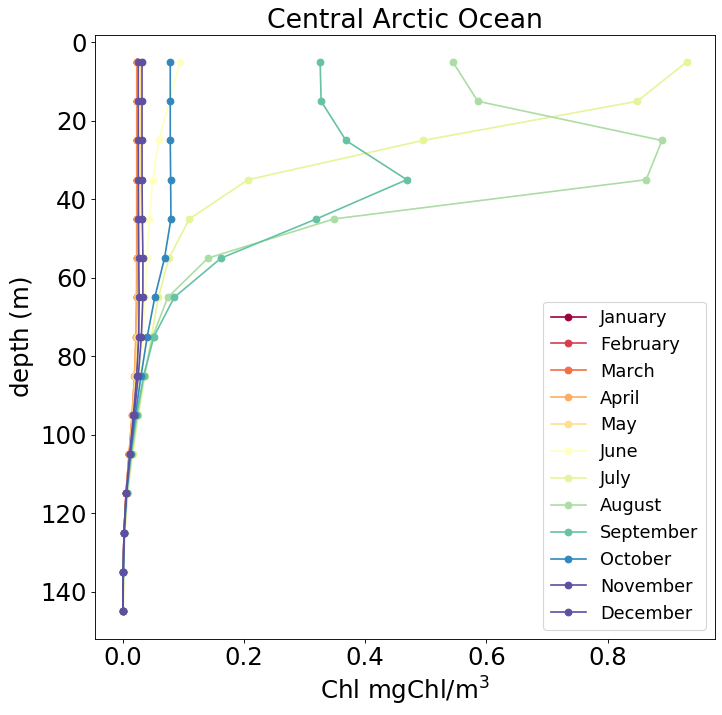

In [39]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 11)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(model_ao[0,:],new.z_t_150m/100, '-o', color=cmap(0),label='January')
pylab.plot(model_ao[1,:],new.z_t_150m/100, '-o',color=cmap(1),label='February')
pylab.plot(model_ao[2,:],new.z_t_150m/100, '-o',color=cmap(2),label='March')
pylab.plot(model_ao[3,:],new.z_t_150m/100, '-o',color=cmap(3),label='April')
pylab.plot(model_ao[4,:],new.z_t_150m/100, '-o',color=cmap(4),label='May')
pylab.plot(model_ao[5,:],new.z_t_150m/100, '-o',color=cmap(5),label='June')
pylab.plot(model_ao[6,:],new.z_t_150m/100, '-o',color=cmap(6),label='July')
pylab.plot(model_ao[7,:],new.z_t_150m/100, '-o',color=cmap(7),label='August')
pylab.plot(model_ao[8,:],new.z_t_150m/100, '-o',color=cmap(8),label='September')
pylab.plot(model_ao[9,:],new.z_t_150m/100, '-o',color=cmap(9),label='October')
pylab.plot(model_ao[10,:],new.z_t_150m/100, '-o',color=cmap(10),label='November')
pylab.plot(model_ao[11,:],new.z_t_150m/100, '-o',color=cmap(11),label='December')

pylab.legend(loc='lower right', fontsize=16)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Chl $mg Chl$/$m^3$', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.title('Central Arctic Ocean', fontsize=24)
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/AO_Chla_depth_monthly_'+year+'year.png', dpi=600, bbox_inches='tight')